In [0]:
!pip install git+https://github.com/gbaydin/hypergradient-descent.git
from hypergrad import SGDHD, AdamHD
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

  Cloning https://github.com/gbaydin/hypergradient-descent.git to /tmp/pip-req-build-7651u780
  Running command git clone -q https://github.com/gbaydin/hypergradient-descent.git /tmp/pip-req-build-7651u780
  Created wheel for hypergrad: filename=hypergrad-0.1-cp36-none-any.whl size=8188 sha256=77299a9a326732dba134f08ca9521349d47af4ba5dd4bf6f175825c687eb084c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ajs0f5aa/wheels/fd/a2/2d/63c4e652ba00bf75e1e0e9ce9628cb47c151bd10322a6cf978
Successfully built hypergrad


In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_set = MNIST('.', train=True, transform=transform, download=True)
test_set = MNIST('.', train=False, transform=transform, download=True)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class MLP(nn.Module) :
    def __init__(self) :
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784,1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000,10)
    def forward(self, x) :
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [0]:
alpha = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
epoch = 50
beta = 1e-4

In [0]:
device = 'cuda:0'
def run(opt, alpha) :
    model = MLP().to(device)
    if opt == 'sgd' :
        optimiser = optim.SGD(model.parameters(), lr=alpha, weight_decay=1e-4)
    if opt == 'sgd-hd' :
        optimiser = SGDHD(model.parameters(), lr=alpha, weight_decay=1e-4, hypergrad_lr=beta)
    if opt == 'adam' :
        optimiser = optim.Adam(model.parameters(), lr=alpha, weight_decay=1e-4)
    if opt == 'adam-hd' :
        optimiser = AdamHD(model.parameters(), lr=alpha, weight_decay=1e-4)
    alpha_epoch = []
    test_epoch = []
    train_epoch = []
    loss_function = F.cross_entropy
    for e in range(epoch):
        loss_sum = 0
        alpha_sum = 0 
        for _, (data, label) in enumerate(train_loader) :
            optimiser.zero_grad()
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = loss_function(out, label)
            loss.backward()
            optimiser.step()
            loss_sum += loss.data
            alpha_sum += optimiser.param_groups[0]['lr']
        loss_sum /= len(train_loader.dataset)
        alpha_sum /= len(train_loader.dataset)
        alpha_epoch.append(alpha_sum)
        train_epoch.append(loss_sum)
        loss_sum = 0
        for _, (data, label) in enumerate(test_loader) :
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = loss_function(out, label)
            loss_sum += loss.data
        loss_sum /= len(test_loader.dataset)
        test_epoch.append(loss_sum)
    return train_epoch, test_epoch, alpha_epoch

In [0]:
sgd = [[],[],[]]
sgd_hd = [[],[],[]]
adam = [[],[],[]]
adam_hd = [[],[],[]]
for a in alpha : 
    train, test, learn = run('sgd', a)
    sgd[0].append(train)
    sgd[1].append(test)
    sgd[2].append(learn)
    train, test, learn = run('sgd-hd', a)
    sgd_hd[0].append(train)
    sgd_hd[1].append(test)
    sgd_hd[2].append(learn)
    train, test, learn = run('adam', a)
    adam[0].append(train)
    adam[1].append(test)
    adam[2].append(learn)
    train, test, learn = run('adam-hd', a)
    adam_hd[0].append(train)
    adam_hd[1].append(test)
    adam_hd[2].append(learn)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


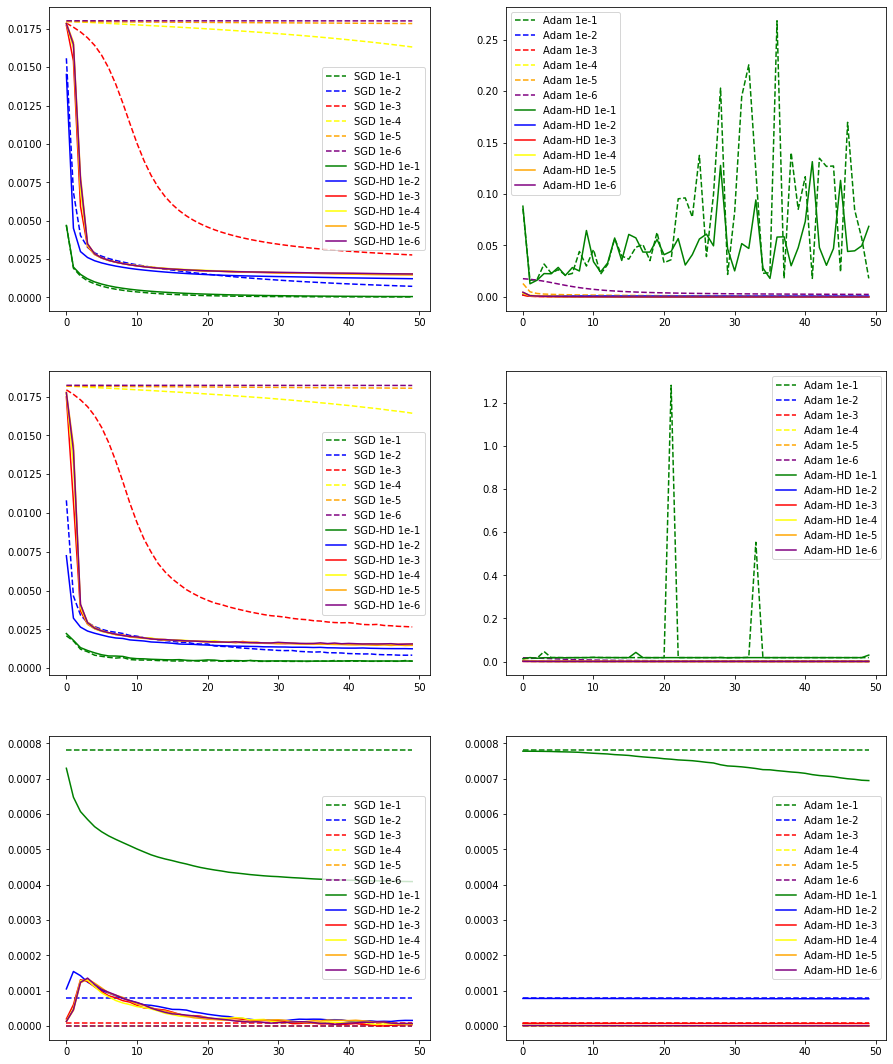

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2,figsize=(15,19))
ax[0][0].plot(range(epoch),sgd[0][0],linestyle='dashed',color='green')
ax[0][0].plot(range(epoch),sgd[0][1],linestyle='dashed',color='blue')
ax[0][0].plot(range(epoch),sgd[0][2],linestyle='dashed',color='red')
ax[0][0].plot(range(epoch),sgd[0][3],linestyle='dashed',color='yellow')
ax[0][0].plot(range(epoch),sgd[0][4],linestyle='dashed',color='orange')
ax[0][0].plot(range(epoch),sgd[0][5],linestyle='dashed',color='purple')
ax[0][0].plot(range(epoch),sgd_hd[0][0],color='green')
ax[0][0].plot(range(epoch),sgd_hd[0][1],color='blue')
ax[0][0].plot(range(epoch),sgd_hd[0][2],color='red')
ax[0][0].plot(range(epoch),sgd_hd[0][3],color='yellow')
ax[0][0].plot(range(epoch),sgd_hd[0][4],color='orange')
ax[0][0].plot(range(epoch),sgd_hd[0][5],color='purple')
ax[0][0].legend(['SGD 1e-1','SGD 1e-2','SGD 1e-3','SGD 1e-4','SGD 1e-5','SGD 1e-6','SGD-HD 1e-1','SGD-HD 1e-2','SGD-HD 1e-3','SGD-HD 1e-4','SGD-HD 1e-5','SGD-HD 1e-6'])
ax[1][0].plot(range(epoch),sgd[1][0],linestyle='dashed',color='green')
ax[1][0].plot(range(epoch),sgd[1][1],linestyle='dashed',color='blue')
ax[1][0].plot(range(epoch),sgd[1][2],linestyle='dashed',color='red')
ax[1][0].plot(range(epoch),sgd[1][3],linestyle='dashed',color='yellow')
ax[1][0].plot(range(epoch),sgd[1][4],linestyle='dashed',color='orange')
ax[1][0].plot(range(epoch),sgd[1][5],linestyle='dashed',color='purple')
ax[1][0].plot(range(epoch),sgd_hd[1][0],color='green')
ax[1][0].plot(range(epoch),sgd_hd[1][1],color='blue')
ax[1][0].plot(range(epoch),sgd_hd[1][2],color='red')
ax[1][0].plot(range(epoch),sgd_hd[1][3],color='yellow')
ax[1][0].plot(range(epoch),sgd_hd[1][4],color='orange')
ax[1][0].plot(range(epoch),sgd_hd[1][5],color='purple')
ax[1][0].legend(['SGD 1e-1','SGD 1e-2','SGD 1e-3','SGD 1e-4','SGD 1e-5','SGD 1e-6','SGD-HD 1e-1','SGD-HD 1e-2','SGD-HD 1e-3','SGD-HD 1e-4','SGD-HD 1e-5','SGD-HD 1e-6'])
ax[2][0].plot(range(epoch),sgd[2][0],linestyle='dashed',color='green')
ax[2][0].plot(range(epoch),sgd[2][1],linestyle='dashed',color='blue')
ax[2][0].plot(range(epoch),sgd[2][2],linestyle='dashed',color='red')
ax[2][0].plot(range(epoch),sgd[2][3],linestyle='dashed',color='yellow')
ax[2][0].plot(range(epoch),sgd[2][4],linestyle='dashed',color='orange')
ax[2][0].plot(range(epoch),sgd[2][5],linestyle='dashed',color='purple')
ax[2][0].plot(range(epoch),sgd_hd[2][0],color='green')
ax[2][0].plot(range(epoch),sgd_hd[2][1],color='blue')
ax[2][0].plot(range(epoch),sgd_hd[2][2],color='red')
ax[2][0].plot(range(epoch),sgd_hd[2][3],color='yellow')
ax[2][0].plot(range(epoch),sgd_hd[2][4],color='orange')
ax[2][0].plot(range(epoch),sgd_hd[2][5],color='purple')
ax[2][0].legend(['SGD 1e-1','SGD 1e-2','SGD 1e-3','SGD 1e-4','SGD 1e-5','SGD 1e-6','SGD-HD 1e-1','SGD-HD 1e-2','SGD-HD 1e-3','SGD-HD 1e-4','SGD-HD 1e-5','SGD-HD 1e-6'])

ax[0][1].plot(range(epoch),adam[0][0],linestyle='dashed',color='green')
ax[0][1].plot(range(epoch),adam[0][1],linestyle='dashed',color='blue')
ax[0][1].plot(range(epoch),adam[0][2],linestyle='dashed',color='red')
ax[0][1].plot(range(epoch),adam[0][3],linestyle='dashed',color='yellow')
ax[0][1].plot(range(epoch),adam[0][4],linestyle='dashed',color='orange')
ax[0][1].plot(range(epoch),adam[0][5],linestyle='dashed',color='purple')
ax[0][1].plot(range(epoch),adam_hd[0][0],color='green')
ax[0][1].plot(range(epoch),adam_hd[0][1],color='blue')
ax[0][1].plot(range(epoch),adam_hd[0][2],color='red')
ax[0][1].plot(range(epoch),adam_hd[0][3],color='yellow')
ax[0][1].plot(range(epoch),adam_hd[0][4],color='orange')
ax[0][1].plot(range(epoch),adam_hd[0][5],color='purple')
ax[0][1].legend(['Adam 1e-1','Adam 1e-2','Adam 1e-3','Adam 1e-4','Adam 1e-5','Adam 1e-6','Adam-HD 1e-1','Adam-HD 1e-2','Adam-HD 1e-3','Adam-HD 1e-4','Adam-HD 1e-5','Adam-HD 1e-6'])
ax[1][1].plot(range(epoch),adam[1][0],linestyle='dashed',color='green')
ax[1][1].plot(range(epoch),adam[1][1],linestyle='dashed',color='blue')
ax[1][1].plot(range(epoch),adam[1][2],linestyle='dashed',color='red')
ax[1][1].plot(range(epoch),adam[1][3],linestyle='dashed',color='yellow')
ax[1][1].plot(range(epoch),adam[1][4],linestyle='dashed',color='orange')
ax[1][1].plot(range(epoch),adam[1][5],linestyle='dashed',color='purple')
ax[1][1].plot(range(epoch),adam_hd[1][0],color='green')
ax[1][1].plot(range(epoch),adam_hd[1][1],color='blue')
ax[1][1].plot(range(epoch),adam_hd[1][2],color='red')
ax[1][1].plot(range(epoch),adam_hd[1][3],color='yellow')
ax[1][1].plot(range(epoch),adam_hd[1][4],color='orange')
ax[1][1].plot(range(epoch),adam_hd[1][5],color='purple')
ax[1][1].legend(['Adam 1e-1','Adam 1e-2','Adam 1e-3','Adam 1e-4','Adam 1e-5','Adam 1e-6','Adam-HD 1e-1','Adam-HD 1e-2','Adam-HD 1e-3','Adam-HD 1e-4','Adam-HD 1e-5','Adam-HD 1e-6'])
ax[2][1].plot(range(epoch),adam[2][0],linestyle='dashed',color='green')
ax[2][1].plot(range(epoch),adam[2][1],linestyle='dashed',color='blue')
ax[2][1].plot(range(epoch),adam[2][2],linestyle='dashed',color='red')
ax[2][1].plot(range(epoch),adam[2][3],linestyle='dashed',color='yellow')
ax[2][1].plot(range(epoch),adam[2][4],linestyle='dashed',color='orange')
ax[2][1].plot(range(epoch),adam[2][5],linestyle='dashed',color='purple')
ax[2][1].plot(range(epoch),adam_hd[2][0],color='green')
ax[2][1].plot(range(epoch),adam_hd[2][1],color='blue')
ax[2][1].plot(range(epoch),adam_hd[2][2],color='red')
ax[2][1].plot(range(epoch),adam_hd[2][3],color='yellow')
ax[2][1].plot(range(epoch),adam_hd[2][4],color='orange')
ax[2][1].plot(range(epoch),adam_hd[2][5],color='purple')
ax[2][1].legend(['Adam 1e-1','Adam 1e-2','Adam 1e-3','Adam 1e-4','Adam 1e-5','Adam 1e-6','Adam-HD 1e-1','Adam-HD 1e-2','Adam-HD 1e-3','Adam-HD 1e-4','Adam-HD 1e-5','Adam-HD 1e-6'])